# NHL Game Predictor
### Important Notes
* When I use the year, it refers to the year the season ends.
    * Like for example the 2024-2025 is marked as 2025.
* nhl-XX.csv is the score data for a given season.
    * Links to get this data is as follows:
      * [2022 Season](https://shanemcd.org/2021/09/23/2021-22-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * [2023 Season](https://shanemcd.org/2022/07/12/2022-23-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * [2024 Season](https://shanemcd.org/2023/08/23/2023-24-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * [2025 Season](https://shanemcd.org/2024/09/07/2024-25-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * All on shanemcd.org, note that I have to redownload the 2025 season data for updated results (csv download of course).
* teamsXX.csv is the team data for a given season.
    * Links to the data is from [MoneyPuck.com](https://moneypuck.com/data.htm)
    * Downloads are from the Team Level

In [34]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from knn import KNN
pd.set_option('display.max_columns', None)

### getTeam(abbreviation)
This returns the team name given the abbrevation

In [4]:
abbrev = pd.read_csv("abbreviations.csv")
abbrev.index = abbrev["Abbrev"]
abbrev = abbrev.drop("Abbrev", axis=1)
abbrev = abbrev.to_dict("index")
abbrev = {k: v['Team'] for k, v in abbrev.items()}
abbrev
def getTeam(text):
    text = text.upper()
    return abbrev[text]

The cell bellow imports the game data and makes only gets the score and winner

In [5]:
def import_games(file):
    game_data = pd.read_csv(file)
    game_data = game_data[game_data["Status"] != "Scheduled"]
    game_data = game_data.rename(columns={"Score": "AwayScore", "Score.1": "HomeScore","Visitor": "Away"})
    game_data["HomeWin"] = game_data["HomeScore"] > game_data["AwayScore"]
    game_data["HomeWin"] = game_data["HomeWin"].astype(int)
    game_data = game_data[["Away","AwayScore","Home","HomeScore","HomeWin"]]
    return game_data
games22 = import_games("nhl-22.csv")
games23 = import_games("nhl-23.csv")
games24 = import_games("nhl-24.csv")
games25 = import_games("nhl-25.csv")
games25

,Away,AwayScore,Home,HomeScore,HomeWin
0,New Jersey Devils,4.0,Buffalo Sabres,1.0,0
1,Buffalo Sabres,1.0,New Jersey Devils,3.0,1
2,St. Louis Blues,3.0,Seattle Kraken,2.0,0
3,Boston Bruins,4.0,Florida Panthers,6.0,1
4,Chicago Blackhawks,2.0,Utah Hockey Club,5.0,1
...,...,...,...,...,...
450,Boston Bruins,1.0,Winnipeg Jets,8.0,1
451,Tampa Bay Lightning,1.0,Edmonton Oilers,2.0,1
452,Minnesota Wild,5.0,Utah Hockey Club,4.0,0
453,St. Louis Blues,4.0,Vancouver Canucks,3.0,0


In [6]:
def get_records(data):
    results = {}
    for i, row in data.iterrows():
        away = row["Away"]
        awayScore = row["AwayScore"]
        home = row["Home"]
        homeScore = row["HomeScore"]
        homeWin = row["HomeWin"]
        # [points scored, points allowed, wins, gp, win%]
        if away not in results:
            results[away] = [0,0,0,0,0]
        if home not in results:
            results[home] = [0,0,0,0,0]
        results[away][3] += 1
        results[home][3] += 1
        if homeWin == 0:
            results[away][2] += 1
        if homeWin == 1:
            results[home][2] += 1
        results[away][0] += awayScore
        results[away][1] += homeScore
        results[home][0] += homeScore
        results[home][1] += awayScore
        results[away][4] = results[away][2] / results[away][3]
        results[home][4] = results[home][2] / results[home][3]
        df = pd.DataFrame.from_dict(results, orient="index", columns=["GS", "GA", "Wins","GP","Win%"])
        df["GD"] = df["GS"] - df["GA"]
        df = df[["GS","GA","GD","Win%"]]
    return df
records22 = get_records(games22)
records23 = get_records(games23)
records24 = get_records(games24)
records25 = get_records(games25)
records25

,GS,GA,GD,Win%
New Jersey Devils,103.0,84.0,19.0,0.580645
Buffalo Sabres,85.0,92.0,-7.0,0.392857
St. Louis Blues,77.0,90.0,-13.0,0.482759
Seattle Kraken,90.0,90.0,0.0,0.466667
Boston Bruins,76.0,95.0,-19.0,0.500000
Florida Panthers,108.0,92.0,16.0,0.620690
Chicago Blackhawks,68.0,87.0,-19.0,0.321429
Utah Hockey Club,83.0,84.0,-1.0,0.428571
Toronto Maple Leafs,82.0,72.0,10.0,0.607143
Montreal Canadiens,78.0,100.0,-22.0,0.392857


In [7]:
def import_teams(file):
    season_data = pd.read_csv(file)
    season_data = season_data[season_data.situation == "all"]
    season_data = season_data.drop(["team.1", "position", "situation", "season", "name"], axis=1)
    season_data["team"] = season_data["team"].apply(getTeam)
    season_data = season_data.reset_index()
    season_data = season_data.drop(["index"], axis=1)
    return season_data

In [8]:
def add_records(teamdata, recorddata):
    teamdata.insert(1,"Win%",0.0)
    teamdata.insert(1,"GD",0)
    teamdata.insert(1,"GA",0)
    teamdata.insert(1,"GS",0)
    for i in recorddata.index:
        current = recorddata.loc[i]
        teamdata.loc[teamdata["team"] == i,"GS"] = current["GS"]
        teamdata.loc[teamdata["team"] == i,"GA"] = current["GA"]
        teamdata.loc[teamdata["team"] == i,"GD"] = current["GD"]
        teamdata.loc[teamdata["team"] == i,"Win%"] = current["Win%"]
    return teamdata

teamdata22 = import_teams("teams22.csv")
teamdata23 = import_teams("teams23.csv")
teamdata24 = import_teams("teams24.csv")
teamdata25 = import_teams("teams25.csv")
add_records(teamdata22, records22)
add_records(teamdata23, records23)
add_records(teamdata24, records24)
add_records(teamdata25, records25)

,team,GS,GA,GD,Win%,games_played,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,Vancouver Canucks,88,87,1,0.518519,27,0.49,0.49,0.48,98624.0,767.91,72.90,50.35,182.23,25.91,426.18,314.44,70.20,73.13,70.43,722.0,350.0,431.0,1503.0,88.0,64.0,9.0,140.0,4.0,368.0,408.0,634.0,984.0,99.0,225.0,763.0,752.0,146.0,373.0,815.0,182.0,75.0,22.07,23.03,27.80,37.0,26.0,25.0,1504.38,1072.0,1073.17,190.0,11.21,13.27,13.27,70.85,71.02,69.13,827.35,75.63,55.45,201.38,27.76,453.73,327.04,72.85,76.34,73.53,766.0,375.0,406.0,1547.0,86.0,67.0,14.0,157.0,0.0,383.0,448.0,680.0,1055.0,93.0,213.0,774.0,528.0,123.0,397.0,877.0,182.0,82.0,23.79,22.49,29.35,41.0,18.0,27.0,1560.63,1141.0,1151.33,190.0,12.40,15.03,15.38,72.66,73.22,71.62
1,Winnipeg Jets,111,76,35,0.700000,30,0.50,0.49,0.49,108414.0,935.29,90.60,61.20,228.46,31.17,507.32,368.33,86.86,92.22,88.45,875.0,413.0,444.0,1732.0,111.0,84.0,14.0,195.0,2.0,401.0,495.0,764.0,1177.0,93.0,210.0,851.0,572.0,161.0,455.0,956.0,231.0,101.0,26.13,27.65,36.82,38.0,32.0,41.0,1767.96,1288.0,1311.15,220.0,13.64,16.90,16.96,87.21,88.70,86.78,951.78,90.96,64.45,237.13,32.61,515.22,376.63,86.36,90.68,86.05,874.0,443.0,486.0,1803.0,76.0,116.0,14.0,206.0,2.0,429.0,488.0,798.0,1241.0,108.0,240.0,883.0,716.0,165.0,457.0,990.0,224.0,103.0,27.38,28.15,35.44,27.0,17.0,32.0,1777.43,1317.0,1306.27,228.0,14.25,22.07,22.07,83.14,82.79,80.47
2,Pittsburgh Penguins,86,116,-30,0.400000,30,0.48,0.50,0.49,109572.0,969.75,96.10,68.75,239.60,33.55,524.55,368.45,91.02,95.86,90.83,887.0,444.0,553.0,1884.0,85.0,125.0,13.0,192.0,2.0,427.0,500.0,802.0,1246.0,97.0,210.0,921.0,580.0,165.0,454.0,952.0,261.0,118.0,26.80,32.43,36.87,31.0,32.0,22.0,1870.57,1331.0,1322.58,202.0,15.21,27.37,27.37,83.93,83.77,81.67,999.50,102.86,66.27,241.15,33.43,532.50,393.80,96.78,104.49,98.32,971.0,399.0,516.0,1886.0,114.0,111.0,13.0,188.0,3.0,429.0,525.

In [9]:
def set_game_stats(games, teams):
    gameStats = games.copy(deep = False)
    difflist = []
    for i, row in gameStats.iterrows():
        awayStats = teams[teams["team"] == row["Away"]]
        homeStats = teams[teams["team"] == row["Home"]]
        awayStats = awayStats.drop(["team"], axis=1)
        homeStats = homeStats.drop(["team"], axis=1)
        diff = pd.DataFrame(np.subtract(homeStats.values, awayStats.values), columns=homeStats.columns)
        diff.index = [i]
        difflist.append(diff)
    difflist = pd.concat(difflist, ignore_index = False)
    difflist = pd.concat([gameStats, difflist], axis=1)
    return difflist
gameStats22 = set_game_stats(games22, teamdata22)
gameStats23 = set_game_stats(games23, teamdata23)
gameStats24 = set_game_stats(games24, teamdata24)
gameStats25 = set_game_stats(games25, teamdata25)
all_game_stats = pd.concat([gameStats22, gameStats23, gameStats24, gameStats25], ignore_index=True)

In [21]:
def getX(gameStats, filters):
    return pd.DataFrame(StandardScaler().fit_transform(gameStats[filters].T).T,columns=filters)
def getY(gameStats):
    return gameStats["HomeWin"]

## Training Model

In [23]:
filter_xgboost = [
    "GS", "GA", "GD", "Win%", "xGoalsPercentage", "corsiPercentage", "fenwickPercentage",
    "shotAttemptsFor", "shotAttemptsAgainst", "xReboundsFor", "xReboundsAgainst",
    "xOnGoalFor", "xOnGoalAgainst", "xGoalsFor", "xGoalsAgainst", "shotsOnGoalFor",
    "shotsOnGoalAgainst", "blockedShotAttemptsFor", "xGoalsFromxReboundsOfShotsFor",
    "unblockedShotAttemptsAgainst", "blockedShotAttemptsAgainst", "takeawaysFor", "takeawaysAgainst",
    "penaltiesFor", "faceOffsWonFor"
]

Testing Accuracy   0.6621129326047359


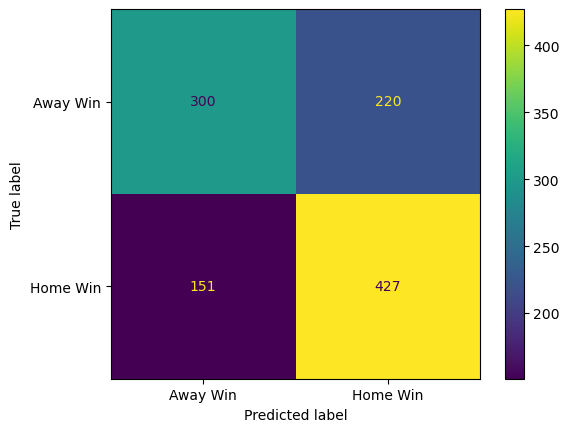

In [ ]:
from xgboost import XGBClassifier
x = getX(all_game_stats, filter_xgboost)
y = getY(all_game_stats)
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.25)
    # model = XGBClassifier(subsample=0.5, reg_lambda=20, reg_alpha=0.5, n_estimators=300, min_child_weight=1, max_depth=100, learning_rate=0.005, gamma=0, colsample_bytree=0.9)
    # model = XGBClassifier(subsample=0.8, reg_lambda=1, reg_alpha=0.01, n_estimators=300, num_parallel_tree=20, min_child_weight=1, max_depth=5, learning_rate=0.005, gamma=0.01, colsample_bytree=0.6)
    # {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'num_parallel_tree': 3, 'n_estimators': 1000, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.001, 'gamma': 0.1, 'colsample_bytree': 0.5}
model = XGBClassifier(subsample=0.7, reg_lambda=0, reg_alpha=0, n_estimators=1000, num_parallel_tree=1, min_child_weight=0, max_depth=5, learning_rate=0.001, gamma=0.1, colsample_bytree=0.5)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

    # print("Training: ", accuracy_score(y_train,model.predict(x_train)))
acc = accuracy_score(y_test,y_pred)
print("Testing Accuracy  ", acc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = ["Away Win", "Home Win"])
cm_display.plot()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300, 500, 700, 1000],
    'num_parallel_tree': [1, 3, 5, 10, 50, 100],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.5, 1],
    'reg_alpha': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1],
    'reg_lambda': [1, 2, 5, 7, 10, 15, 20]
}
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
random_search.fit(x_train, y_train)
for i, score in enumerate(random_search.cv_results_['mean_test_score']):
    print(f"Iteration {i+1}: Accuracy = {score:.4f}, Params = {random_search.cv_results_['params'][i]}")
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Iteration 1: Accuracy = 0.5870, Params = {'subsample': 0.5, 'reg_lambda': 15, 'reg_alpha': 0.1, 'num_parallel_tree': 5, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0, 'colsample_bytree': 0.5}
Iteration 2: Accuracy = 0.6119, Params = {'subsample': 1.0, 'reg_lambda': 20, 'reg_alpha': 0.5, 'num_parallel_tree': 3, 'n_estimators': 500, 'min_child_weight': 6, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 1.0}
Iteration 3: Accuracy = 0.6180, Params = {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.1, 'num_parallel_tree': 5, 'n_estimators': 200, 'min_child_weight': 8, 'max_depth': 7, 'learning_rate': 0.005, 'gamma': 0.5, 'colsample_bytree': 1.0}
Iteration 4: Accuracy = 0.6216, Params = {'subsample': 0.5, 'reg_lambda': 20, 'reg_alpha': 0.05, 'num_parallel_tree': 3, 'n_estimators': 500, 'min_child_weight': 8, 'max_depth': 10, 'learning_rate': 0.01, 'gamma'

In [ ]:
random_search.cv_results_

{'mean_fit_time': array([25.80524667, 67.76076428, 48.18712926, 22.48877152, 84.92110602,
        42.72163955,  4.66580772,  0.33817856,  5.8127141 ,  3.19515117]),
 'std_fit_time': array([0.0994668 , 0.46629018, 0.20164189, 0.19886853, 0.54442881,
        5.60039294, 0.71160798, 0.0374231 , 0.23581784, 0.24592442]),
 'mean_score_time': array([0.26540017, 0.64718032, 0.46591719, 0.24497032, 0.70346109,
        0.21077013, 0.05473789, 0.00838717, 0.08798575, 0.02881106]),
 'std_score_time': array([0.01437178, 0.0174121 , 0.020618  , 0.02043043, 0.0156811 ,
        0.03754684, 0.00510744, 0.00332129, 0.02767781, 0.00815863]),
 'param_subsample': masked_array(data=[0.9, 0.9, 0.7, 0.9, 0.8, 1.0, 0.6, 1.0, 0.6, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_reg_lambda': masked_array(data=[5, 7, 10, 1, 5, 7, 7, 20, 2, 5],
              mask=[False, False, False, F

In [18]:
def getTeam(team, stats):
    return stats.loc[stats["team"] == team]

def getGameSet(awayTeam, homeTeam):
    awayTeam = awayTeam.drop(["team"], axis=1)
    homeTeam = homeTeam.drop(["team"], axis=1)
    diff = pd.DataFrame(np.subtract(homeTeam.values, awayTeam.values), columns=homeTeam.columns)
    return diff

In [82]:
away = getTeam("Anaheim Ducks", teamdata25)
home = getTeam("Montreal Canadiens", teamdata25)
gameSet = getGameSet(away, home)
prediction = getX(gameSet, filter_xgboost)
result = model.predict(prediction.values)
result = (result >= 0.5).astype(int)
print(result)
prediction

[1]


,GS,GA,GD,Win%,xGoalsPercentage,corsiPercentage,fenwickPercentage,shotAttemptsFor,shotAttemptsAgainst,xReboundsFor,xReboundsAgainst,xOnGoalFor,xOnGoalAgainst,xGoalsFor,xGoalsAgainst,shotsOnGoalFor,shotsOnGoalAgainst,blockedShotAttemptsFor,xGoalsFromxReboundsOfShotsFor,unblockedShotAttemptsAgainst,blockedShotAttemptsAgainst,takeawaysFor,takeawaysAgainst,penaltiesFor,faceOffsWonFor
0,0.443929,0.639422,-0.142552,0.053172,0.052942,0.052662,0.052662,-1.511007,-0.505611,-0.052904,-0.027211,-1.951426,-0.975913,0.020546,0.020825,-1.064164,-0.449756,0.862843,0.030599,-1.622717,1.170048,0.611495,0.30429,0.862843,3.124983


In [84]:
# import pickle
# file_name = "xgb.pkl"
# pickle.dump(model, open(file_name, "wb"))

In [56]:
file_name = "xgb.pkl"
test = pickle.load(open(file_name,"rb"))

In [83]:
away = getTeam("Washington Capitals", teamdata25)
home = getTeam("Columbus Blue Jackets", teamdata25)
gameSet = getGameSet(away, home)
prediction = getX(gameSet, filter_xgboost)
result = test.predict(prediction.values)
result = (result >= 0.5).astype(int)
print(result)
prediction

[0]


,GS,GA,GD,Win%,xGoalsPercentage,corsiPercentage,fenwickPercentage,shotAttemptsFor,shotAttemptsAgainst,xReboundsFor,xReboundsAgainst,xOnGoalFor,xOnGoalAgainst,xGoalsFor,xGoalsAgainst,shotsOnGoalFor,shotsOnGoalAgainst,blockedShotAttemptsFor,xGoalsFromxReboundsOfShotsFor,unblockedShotAttemptsAgainst,blockedShotAttemptsAgainst,takeawaysFor,takeawaysAgainst,penaltiesFor,faceOffsWonFor
0,-0.951034,0.540492,-1.957814,-0.476547,-0.468898,-0.465915,-0.466661,1.547272,0.689645,-0.463678,-0.326085,0.164254,0.859306,-1.163577,-0.221678,2.069306,1.137102,0.465916,-0.473,1.99473,-1.771373,0.242187,0.242187,-0.056118,-0.690017


0.7069004782509679


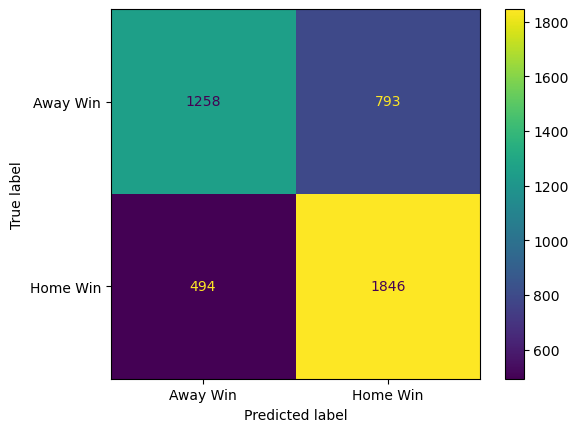

In [101]:
x = getX(all_game_stats, filter_xgboost)
y = getY(all_game_stats)
prediction = test.predict(x)
print(accuracy_score(y,prediction))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y,prediction), display_labels = ["Away Win", "Home Win"])
cm_display.plot()
plt.show()

<Axes: >

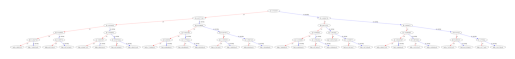

In [ ]:
import graphviz

from xgboost import plot_tree
plot_tree(test)